In [33]:
import os
import numpy as np
import tensorflow as tf
import cv2

DATA_DIR = "./data/1/PetImages"
IMG_SIZE = (128, 128)
MAX_SAMPLES_PER_CLASS = 7000

cat_images, dog_images = [], []
cat_labels, dog_labels = [], []

# Helper to read and resize safely
def load_and_resize(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    return img / 255.0

# Load Cat images
for fname in os.listdir(os.path.join(DATA_DIR, "Cat")):
    if len(cat_images) >= MAX_SAMPLES_PER_CLASS:
        break
    img_path = os.path.join(DATA_DIR, "Cat", fname)
    img = load_and_resize(img_path)
    if img is not None:
        cat_images.append(img)
        cat_labels.append(0)

# Load Dog images
for fname in os.listdir(os.path.join(DATA_DIR, "Dog")):
    if len(dog_images) >= MAX_SAMPLES_PER_CLASS:
        break
    img_path = os.path.join(DATA_DIR, "Dog", fname)
    img = load_and_resize(img_path)
    if img is not None:
        dog_images.append(img)
        dog_labels.append(1)

# Stack all and convert to tensors
all_images = np.array(cat_images + dog_images, dtype=np.float32)
all_labels = np.array(cat_labels + dog_labels, dtype=np.int32)

# Shuffle the dataset
shuffle_indices = np.random.permutation(len(all_images))
all_images = all_images[shuffle_indices]
all_labels = all_labels[shuffle_indices]

# Convert to tensors
all_images_tensor = tf.convert_to_tensor(all_images)
all_labels_tensor = tf.convert_to_tensor(all_labels)

# Split indices
train_idx = 0
val_idx = 5000
test_idx = 6000

# Training set
images_train = all_images_tensor[train_idx:val_idx]
labels_train = all_labels_tensor[train_idx:val_idx]
final_dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train)).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Validation set
images_val = all_images_tensor[val_idx:test_idx]
labels_val = all_labels_tensor[val_idx:test_idx]
final_dataset_val = tf.data.Dataset.from_tensor_slices((images_val, labels_val)).batch(32)

# Test set
images_test = all_images_tensor[test_idx:test_idx + 1000]
labels_test = all_labels_tensor[test_idx:test_idx + 1000]
final_dataset_test = tf.data.Dataset.from_tensor_slices((images_test, labels_test)).batch(32)

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


In [54]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    # layers.RandomContrast(0.1)

])

augmented_dataset = final_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

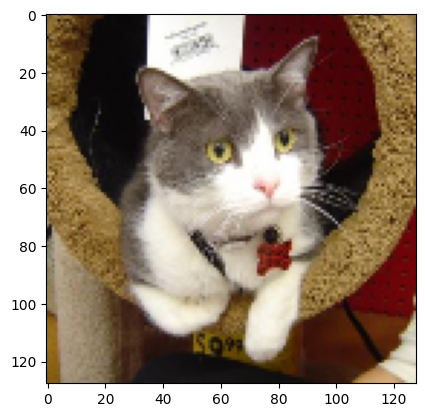

In [125]:
from matplotlib import pyplot as plt
images, labels = next(iter(final_dataset.take(1)))
plt.imshow(images[0])

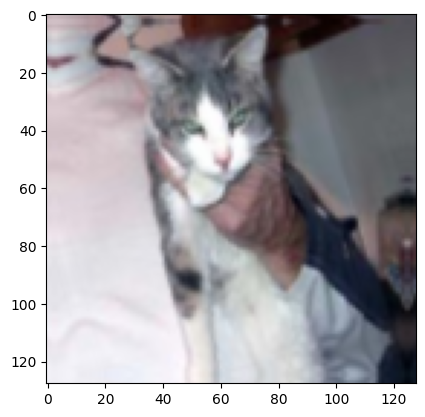

In [61]:
from matplotlib import pyplot as plt
images, labels = next(iter(augmented_dataset.take(1)))
plt.imshow(images[0])

In [57]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available: 1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


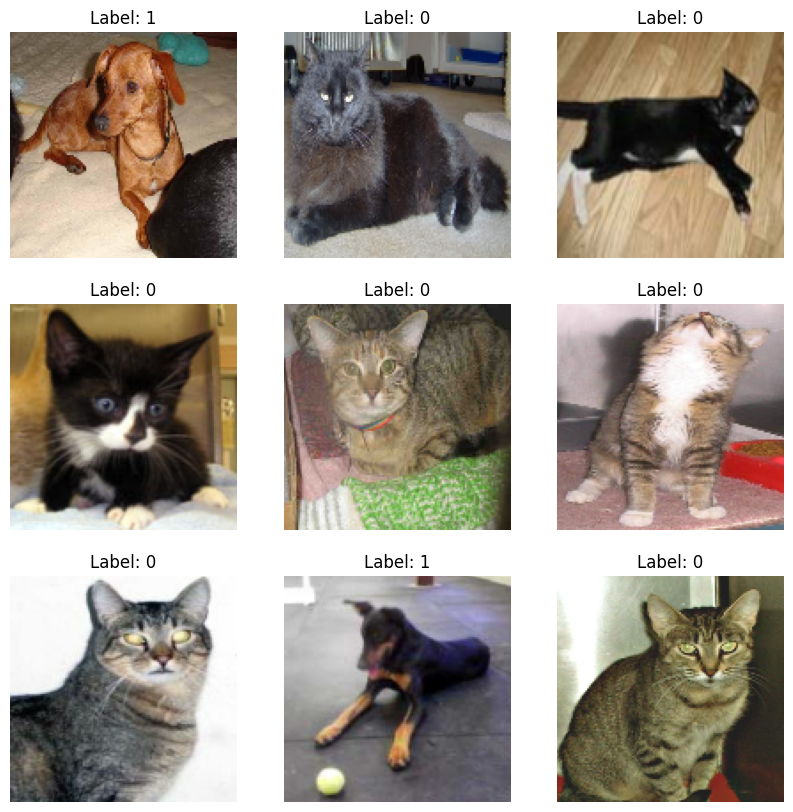

2025-05-11 21:51:39.546706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [130]:
from matplotlib import pyplot as plt

for images, labels in final_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow((images[i].numpy() * 255.).astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()

In [129]:
images[0]

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.5137255 , 0.5176471 , 0.5372549 ],
        [0.52156866, 0.5254902 , 0.54509807],
        [0.5372549 , 0.5411765 , 0.56078434],
        ...,
        [0.1882353 , 0.21176471, 0.20392157],
        [0.18039216, 0.20392157, 0.19607843],
        [0.17254902, 0.19607843, 0.1882353 ]],

       [[0.52156866, 0.5254902 , 0.54509807],
        [0.5294118 , 0.5372549 , 0.5568628 ],
        [0.53333336, 0.5372549 , 0.5568628 ],
        ...,
        [0.19215687, 0.21568628, 0.20784314],
        [0.18431373, 0.20784314, 0.2       ],
        [0.18039216, 0.20392157, 0.19607843]],

       [[0.5294118 , 0.53333336, 0.5529412 ],
        [0.5372549 , 0.5411765 , 0.56078434],
        [0.54901963, 0.5529412 , 0.57254905],
        ...,
        [0.19607843, 0.21960784, 0.21176471],
        [0.1882353 , 0.21176471, 0.20392157],
        [0.1882353 , 0.21176471, 0.20392157]],

       ...,

       [[0.0627451 , 0.06666667, 0.04313726],
        [0.08

In [96]:
import tensorflow as tf
from keras.models import load_model
from keras.callbacks import EarlyStopping
import keras

from keras import layers, models

model = models.Sequential()
model.add(layers.Input(shape=(128, 128, 3)))  # defines model.input
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

history = model.fit(augmented_dataset, 
          epochs=50, 
          callbacks=callbacks,
          validation_data=final_dataset_val)
# model = load_model("model.keras")

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.5628 - loss: 0.7267 - val_accuracy: 0.5080 - val_loss: 0.7310 - learning_rate: 0.0010
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.6332 - loss: 0.6724 - val_accuracy: 0.5090 - val_loss: 0.8063 - learning_rate: 0.0010
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.6626 - loss: 0.6431 - val_accuracy: 0.5440 - val_loss: 0.7175 - learning_rate: 0.0010
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.6760 - loss: 0.6220 - val_accuracy: 0.6130 - val_loss: 0.6721 - learning_rate: 0.0010
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.6994 - loss: 0.6038 - val_accuracy: 0.5690 - val_loss: 0.7501 - learning_rate: 0.0010
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.7171 - loss: 0.5706 - val_accuracy: 0.5470 - val_loss: 1.2162 - learning_rate: 0.0010
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.7303 - l

In [102]:
base = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(128,128,3), weights='imagenet')
base.trainable = False

model = tf.keras.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history = model.fit(augmented_dataset, 
          epochs=50, 
          callbacks=callbacks,
          validation_data=final_dataset_val)

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.8854 - loss: 0.2602 - val_accuracy: 0.9410 - val_loss: 0.1245 - learning_rate: 0.0010
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.9335 - loss: 0.1697 - val_accuracy: 0.9600 - val_loss: 0.0911 - learning_rate: 0.0010
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9448 - loss: 0.1288 - val_accuracy: 0.9680 - val_loss: 0.0772 - learning_rate: 0.0010
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9347 - loss: 0.1514 - val_accuracy: 0.9560 - val_loss: 0.1058 - learning_rate: 0.0010
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9370 - loss: 0.1412 - val_accuracy: 0.9730 - val_loss: 0.0701 - learning_rate: 0.0010
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9516 - loss: 0.1223 - val_accuracy: 0.9640 - val_loss: 0.0909 - learning_rate: 0.0010
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9491 - loss: 0

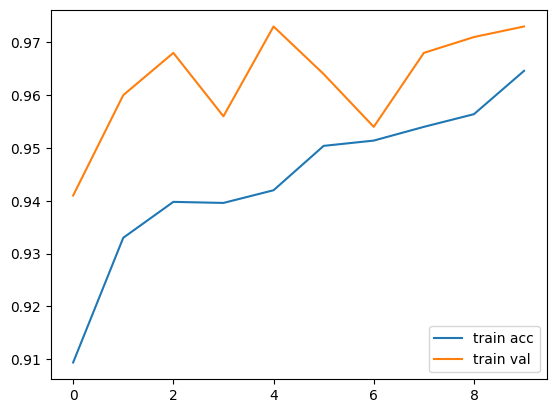

In [121]:
history.history.get("accuracy")

acc_train = history.history.get("accuracy")
acc_val = history.history.get("val_accuracy")

plt.plot(acc_train, label="train acc")
plt.plot(acc_val, label="train val")

plt.legend()

In [122]:
model.save("model.keras")

In [ ]:
model.evaluate(

In [123]:
loss, accuracy = model.evaluate(final_dataset_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9586 - loss: 0.0980 


In [62]:
from keras import Model

intermediate_model = Model(
    inputs=model.layers[0].input,
    outputs=model.layers[1].output  # last Conv2D layer
)

last_conv_model = Model(
    inputs=model.layers[0].input,
    outputs=model.layers[5].output  # last Conv2D layer
)

In [365]:
intermediate_model.layers[:5]

[<InputLayer name=input_layer_21, built=True>,
 <Conv2D name=conv2d_63, built=True>,
 <MaxPooling2D name=max_pooling2d_40, built=True>]

In [63]:
import random

test_dataset = []
labels = []
for i in range(10):
    if random.choice([1, 2]) == 1:
        test_dataset.append(random.choice(cat_images[:5000]))
        labels.append(0)
    else:
        test_dataset.append(random.choice(dog_images[:5000]))
        labels.append(1)

In [455]:
labels

[0, 0, 1, 1, 1, 0, 0, 0, 1, 0]

In [106]:
test_dataset_t = tf.convert_to_tensor(test_dataset * 255)

In [103]:
prediction = model.predict(test_dataset_t)
# intermediate_prediction = tf.convert_to_tensor(intermediate_model.predict(test_dataset_t))
# last_prediction = tf.convert_to_tensor(last_conv_model.predict(test_dataset_t).reshape(10, 32, 32, 32))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [451]:
# titles = ["dog" if x[0] > 0.5 else "cat" for x in prediction]

In [371]:
# y = np.expand_dims(prediction[0].reshape(28, 28, 64), axis=0)

In [111]:
labels_pred = [1 if x[0] > 0.5 else 0 for x in prediction]

In [113]:
prediction

array([[9.9967921e-01],
       [6.9275557e-04],
       [9.9545068e-01],
       [1.8656745e-05],
       [9.9999058e-01],
       [6.7604574e-06],
       [1.7417374e-04],
       [9.9958986e-01],
       [1.3787294e-03],
       [4.2004506e-03]], dtype=float32)

In [114]:
labels, labels_pred

([1, 0, 1, 0, 1, 0, 0, 1, 0, 0], [1, 0, 1, 0, 1, 0, 0, 1, 0, 0])

In [115]:
titles = ["dog" if x == 1 else "cat" for x in labels_pred]

In [116]:
last_prediction.shape

TensorShape([10, 32, 32, 32])

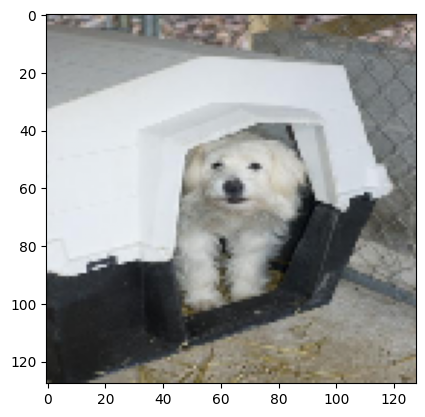

In [117]:
target_index=-3
plt.imshow(test_dataset[target_index])

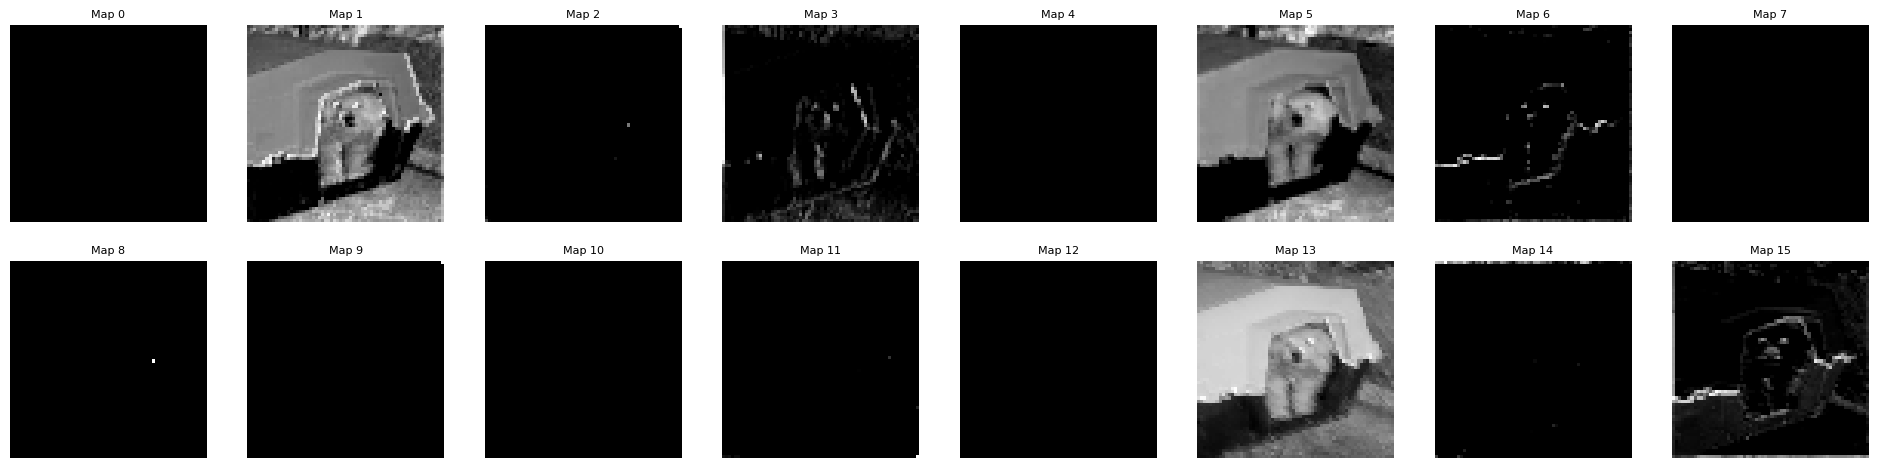

In [118]:
plt.figure(figsize=(24, 24))
for i in range(16):
    plt.subplot(8, 8, i + 1)
    plt.imshow(intermediate_prediction[target_index,:, :, i].numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f"Map {i}", fontsize=8)

# plt.tight_layout()
plt.show()

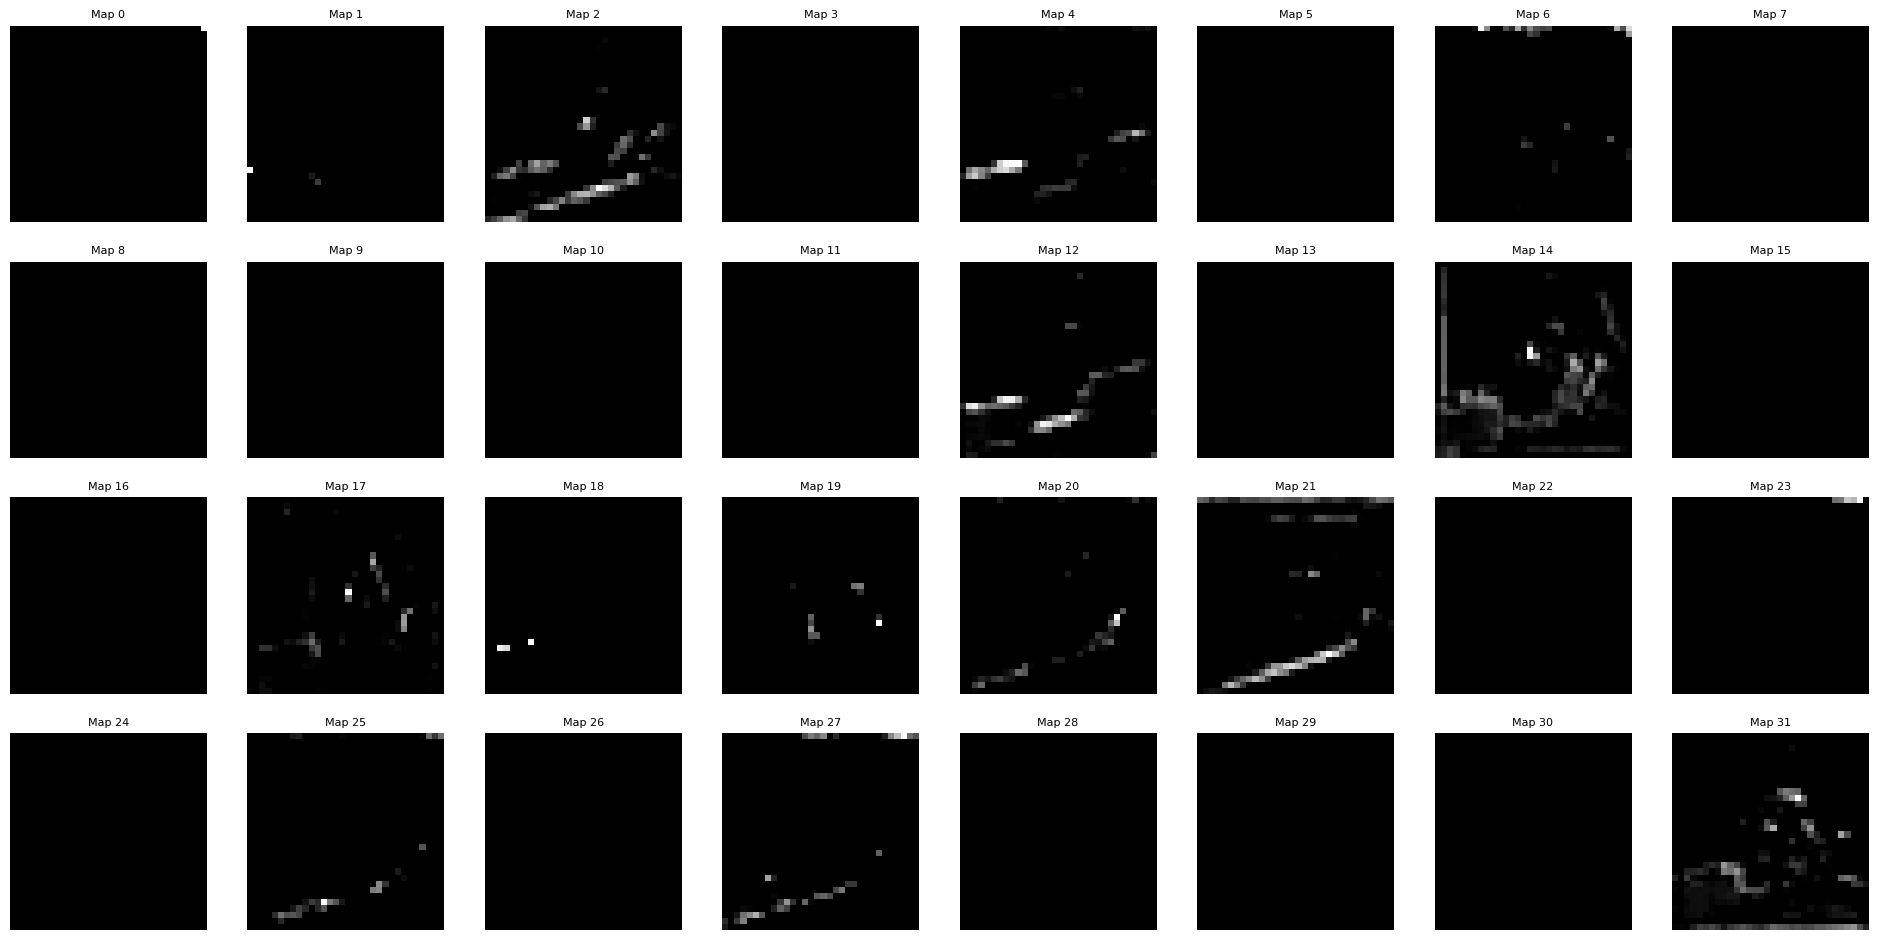

In [119]:
plt.figure(figsize=(24, 24))
for i in range(32):
    plt.subplot(8, 8, i + 1)
    plt.imshow(last_prediction[target_index,:, :, i].numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f"Map {i}", fontsize=8)

# plt.tight_layout()
plt.show()

In [354]:
last_prediction.shape

(10, 65536)

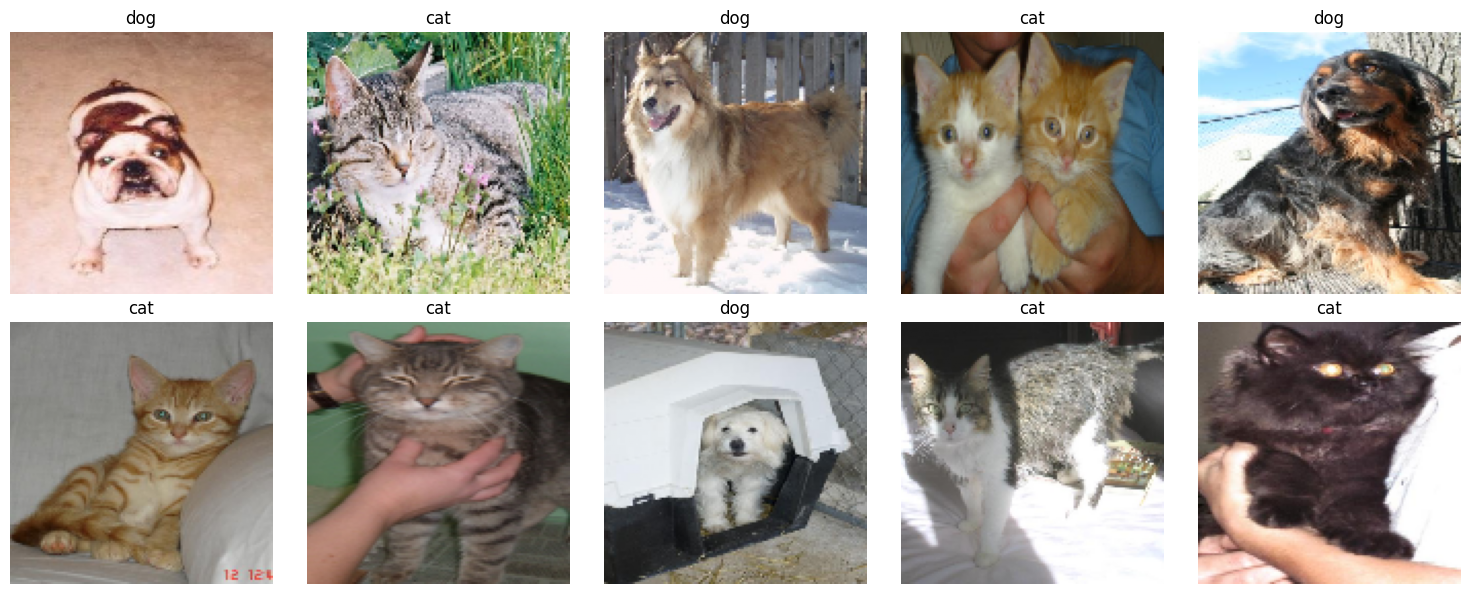

In [124]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns
axes = axes.flatten()  # flatten to 1D array for easier indexing

for i in range(10):
    axes[i].imshow(test_dataset[i])
    axes[i].set_title(titles[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [141]:
prediction


In [142]:
titles

['dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog']

In [134]:
len(labels)

10

In [125]:
import random

random.choice(cat_samples_t)

<tf.Tensor: shape=(128, 128, 3), dtype=uint8, numpy=
array([[[178,  28,   3],
        [180,  30,   5],
        [183,  33,   8],
        ...,
        [ 76,  44,  19],
        [ 76,  44,  19],
        [ 75,  43,  20]],

       [[183,  33,   8],
        [185,  35,  10],
        [183,  33,   8],
        ...,
        [ 66,  38,  17],
        [ 66,  39,  17],
        [ 71,  43,  22]],

       [[183,  33,   8],
        [183,  33,   8],
        [187,  36,  11],
        ...,
        [ 62,  37,  17],
        [ 62,  37,  17],
        [ 58,  33,  11]],

       ...,

       [[244, 119, 156],
        [241, 114, 155],
        [243, 117, 157],
        ...,
        [ 41,  51,  60],
        [ 22,  33,  40],
        [ 48,  52,  62]],

       [[233, 111, 150],
        [236, 114, 153],
        [237, 116, 151],
        ...,
        [ 39,  49,  59],
        [ 37,  48,  58],
        [ 53,  63,  72]],

       [[237, 112, 152],
        [234, 109, 148],
        [241, 117, 153],
        ...,
        [ 37,  47,  5

In [432]:
images, labels = next(iter(final_dataset.take(1)))

In [436]:
result = model.predict(images * 255)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [437]:
(result > 0.5).astype(np.int32)

array([[0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0]], dtype=int32)

In [435]:
result

array([[1.1622592e-34],
       [1.5934039e-32],
       [1.5408593e-34],
       [1.2421136e-33],
       [9.5209257e-34],
       [5.3213128e-34],
       [3.4147749e-37],
       [2.0023139e-34],
       [1.1767903e-33],
       [4.2620532e-34],
       [0.0000000e+00],
       [3.1934795e-35],
       [1.4847348e-31],
       [5.3808360e-34],
       [2.2459633e-32],
       [4.5488234e-32],
       [2.0404221e-32],
       [3.6584698e-33],
       [2.0708604e-34],
       [5.1600854e-37],
       [8.9644720e-35],
       [2.8713880e-35],
       [3.5252341e-34],
       [3.8919814e-35],
       [2.8295802e-34],
       [2.4400058e-33],
       [6.6106648e-36],
       [9.1285321e-33],
       [8.3058742e-36],
       [1.9319005e-38],
       [1.8121246e-33],
       [4.2389803e-33]], dtype=float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
This is a damn dog


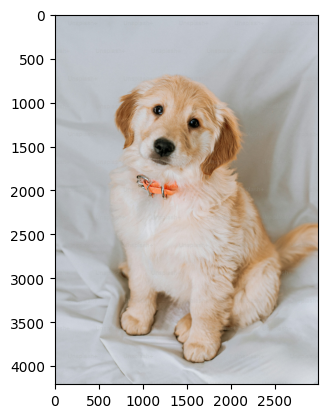

In [161]:
import cv2

dog = cv2.imread("dog.jpeg")
dog = cv2.cvtColor(dog, cv2.COLOR_BGR2RGB)
plt.imshow(dog)
dog = cv2.resize(dog, (128, 128))
dog_t = tf.convert_to_tensor(dog)
dog_t = tf.cast(dog_t, tf.float32)
dog_t = tf.expand_dims(dog_t, axis=0)
dog_t = dog_t / 255.
prediction = model.predict(dog_t)

if prediction > 0.5:
    print("This is a damn dog")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
This is a damn cat


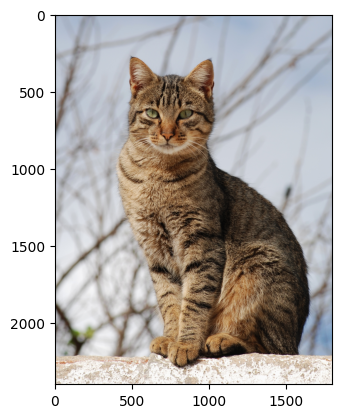

In [164]:
import cv2

cat = cv2.imread("cat.jpg")
cat = cv2.cvtColor(cat, cv2.COLOR_BGR2RGB)
plt.imshow(cat)
cat = cv2.resize(cat, (128, 128))
cat_t = tf.convert_to_tensor(cat)
cat_t = tf.cast(cat_t, tf.float32)
cat_t = tf.expand_dims(cat_t, axis=0)
cat_t = cat_t / 255.
prediction = model.predict(cat_t)

if prediction > 0.5:
    print("This is a damn dog")
else:
    print("This is a damn cat")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
This is a damn dog


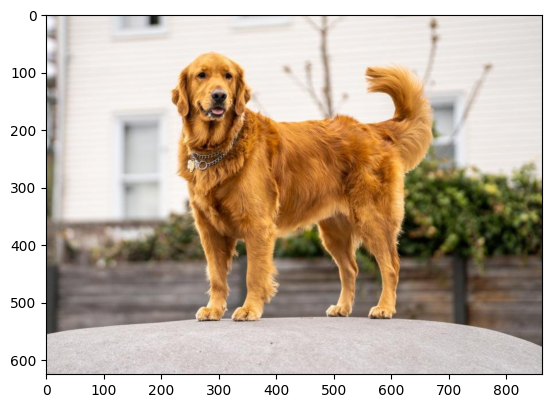

In [166]:
import cv2

cat = cv2.imread("dog2.jpeg")
cat = cv2.cvtColor(cat, cv2.COLOR_BGR2RGB)
plt.imshow(cat)
cat = cv2.resize(cat, (128, 128))
cat_t = tf.convert_to_tensor(cat)
cat_t = tf.cast(cat_t, tf.float32)
cat_t = tf.expand_dims(cat_t, axis=0)
cat_t = cat_t / 255.
prediction = model.predict(cat_t)

if prediction > 0.5:
    print("This is a damn dog")
else:
    print("This is a damn cat")

In [147]:
dog_t.shape

TensorShape([1, 128, 128, 3])

In [134]:
!open .